## Flow Model

Any generative model especially in the image space are considered as transport problem. U will start from one distribution (usually random or uniform) and move to another distribution (data distribution). The reason for doing this is that we don't know data distribution and only have i.i.d samples (aka data), also the data distribution is often complex and difficult to sample from. SDE, DDPM, Normalizing flows, continous flows, GANs and VAEs are some of these approaches. 

while training any generative models, we would like to have some nice properties. 
- Generate high quality images/videos. 
- Optimal cost of inference. 
- Deterministic. 

To our advantage, there is one paper which explains us how to do this [Flow Straight and Fast: Learning to Generate and Transfer Data with Rectified Flow](https://arxiv.org/pdf/2209.03003)

## Pre-requsites
- Ordinary Differential equations
- ODE solvers.


Flow is designed as an optimal transport problem. we transport images from one distribution $\pi_{0}$ (noise) to another distribution $\pi_{1}$ (data distribution). the following are the set of equations defined in the paper.

$$
x_{t} = tx_{1}+(1-t)x_{0} \tag{1}
$$

$$
\frac{dx_{t}}{dt} = x_{1} - x_{0} \tag{2}
$$

the goal of the neural network is to learn the above differential equation. we sample t and find x_{t} using eq(1) and then we will pass x_{t} and t to the neural network T(x_t, t) and get an output. 

the optimization problem is to solve 

$$
\int_{0}^{t} ||(x_{1} - x_{0}) - (T(x_{t}, t))||^{2}_{2} \tag{2}
$$

How do we sample t? we know that t should be between 0-1, so we can use any distribution which samples and produces numbers within this range. so we can use simple uniform distribution or logit normal distribution (this is from another paper, which experimented with different distribution and found this to work better). we will discuss more about this later

## Psuedo algorithm while training
- take a batch of images $x_{1}$
- sample noise $x_{0}$
- sample a t for each image. use $x_{1}$, $x_{0}$ and $t$ to produce $x_{t}$
- use neural network T($x_{t}$, t) to process the inputs.
- calculate mean squared error as given in eq(3)
- repeat the process.

this is it, the model is trained and evaluated in the entire ambient space. think of Neural network is in y axis and t is in x axis, we know the gradient (direction) at each and every point. 

## Inference.
since we know the starting point ($x_{0}$), and direction is given by the neural network at the point, we can use euler's method to transport this noise and generate an image. 

$$
x_{t} = x_{t-1}+ \nabla_{t} f(x_{t-1}, t-1) 
$$

if we use t = 0.1 as step size, then we find the images as $x_{0.1}$, $x_{0.2}$, $x_{0.3}$, ... $x_{1}$. this took 10 evaluation steps. if we use a step size of 0.01, we use 100 steps.

we can also use advanced numerical solvers like  RK2 .. RK5 to solve the ODE and generate new samples. we will see with code below on how to do this. 


Fundamentally this is what flow means. Simple and Clean

## Some interesting properties mentioned in the paper
- Flow path don't cross each other (aka non-crossing property). In the ambient space, if u take any point we get only one gradient, if a crossing is present, at that point, we need to have two different values for $dx_{t}/dt$ which is not possible in ODE setting. so if you sample 10 points from $\pi_{0}$ traverse the path to $\pi_{1}$ u will see that none of them meet at any point. 
- the probability is preserved throughout the flow. Law($X_{t}$) = Law($Z_{t}$). Here $z_{t}$ is model output and $X_{t}$ is obtained using linear equation described here
- Reducing transport costs. the cost of transporting $z_{0}$ to $z_{1}$ is always lower than cost of transporting $x_{0}$ to $x_{1}$ no matter whatever cost function u use. this allows us to not worry about the cost function.
- Reflow, straightening and fast simulation. if we train a new model on $z_{0}$ to $z_{1}$ then it is called reflow-1, if we again train on reflow-1 outputs, it is called reflow-2. As more reflow's occur the paths become more straight which allows to simulate fast during inference. 
- when doing image to image translation, it is better to add a small noise to inputs as this will lead to a smooth input variable. 

In [1]:
# Looad required libraries 

import torch 
import numpy as np
import torchvision
from tqdm import tqdm
import matplotlib.pyplot as plt
plt.style.use('bmh')
%matplotlib inline

In [2]:
# Now say we have MNIST data in the shape of (N, 1, 28, 28)
# we will create a VAE model to generate new images similar to the training data. 

# Load MNIST data 

# Load MNIST data and resize it to 64x64
train_loader = torch.utils.data.DataLoader(
    torchvision.datasets.MNIST('data/', train=True, download=True,
                                transform=torchvision.transforms.Compose([
                                    torchvision.transforms.Pad(2),
                                    torchvision.transforms.ToTensor(),
                                ])),
    batch_size=128, shuffle=True)

val_loader = torch.utils.data.DataLoader(
    torchvision.datasets.MNIST('data/', train=False, download=True,
                                transform=torchvision.transforms.Compose([
                                    torchvision.transforms.Pad(2),
                                    torchvision.transforms.ToTensor(),
                                ])),
    batch_size=128, shuffle=False)

len(train_loader), len(val_loader)

(469, 79)

In [3]:
imgs, labels = next(iter(train_loader))
imgs.shape, labels.shape

(torch.Size([128, 1, 32, 32]), torch.Size([128]))

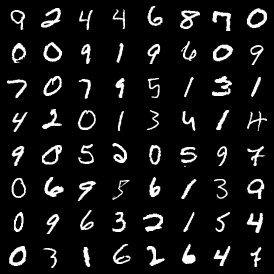

In [4]:
torchvision.transforms.ToPILImage()(torchvision.utils.make_grid(imgs[:64], nrow=8, normalize=False))

# first lets train using linear flow 

In [5]:
time = torch.distributions.Uniform(0, 1)
time.sample((10,))

tensor([0.9275, 0.5279, 0.4794, 0.2384, 0.2047, 0.6944, 0.5725, 0.7129, 0.6208,
        0.6518])

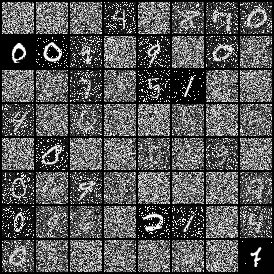

In [6]:
# eq = xt = tx1 + (1-t)x0 where x0 is pure noise and x1 is the original name 
bs = imgs.shape[0]
t = time.sample((bs,)).unsqueeze(1).unsqueeze(1).unsqueeze(1)
noise = torch.randn_like(imgs)
xt = t*(2*imgs-1) + (1-t)*noise
torchvision.transforms.ToPILImage()(torchvision.utils.make_grid((xt[:64]+1)/2, nrow=8, normalize=False))

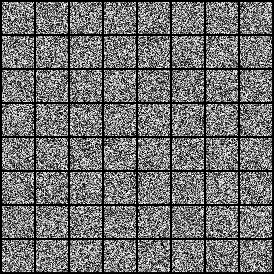

In [7]:
target = (2*imgs-1) - noise
torchvision.transforms.ToPILImage()(torchvision.utils.make_grid(target[:64], nrow=8, normalize=False))

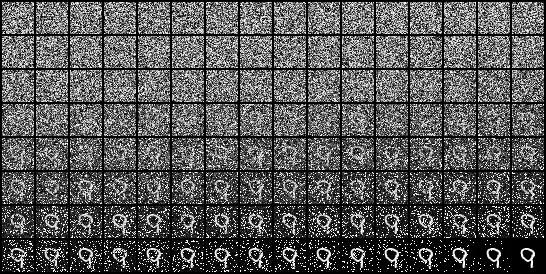

In [8]:
# lets also look how same image looks at different timesteps
simgs = imgs[0].unsqueeze(0).repeat(128, 1, 1, 1)
bs = simgs.shape[0]
t = torch.linspace(0, 1, bs).unsqueeze(1).unsqueeze(1).unsqueeze(1)
noise = torch.randn_like(simgs)
sxt = (t)*(2*simgs-1) + (1-t)*noise
torchvision.transforms.ToPILImage()(torchvision.utils.make_grid((sxt+1)/2, nrow=16, normalize=False))

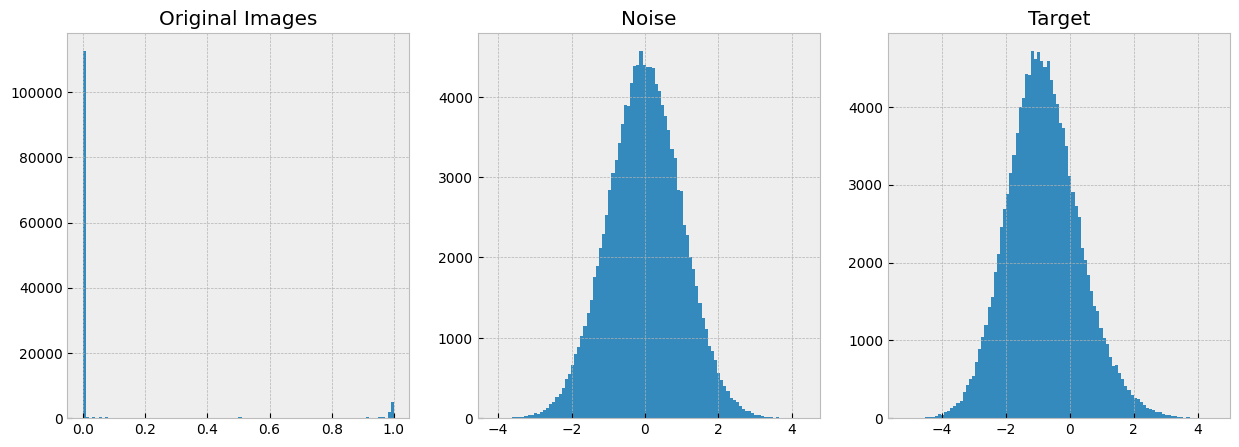

In [9]:
fig, ax = plt.subplots(1, 3, figsize=(15, 5))
ax[0].hist(imgs.view(-1).numpy(), bins=100)
ax[0].set_title('Original Images')
ax[1].hist(noise.view(-1).numpy(), bins=100)
ax[1].set_title('Noise')
ax[2].hist(target.view(-1).numpy(), bins=100)
ax[2].set_title('Target')
plt.show()

## network

In [10]:
from diffusers import UNet2DModel

device = "cuda"

model = UNet2DModel(
    sample_size=32,
    in_channels=1,
    out_channels=1,
    layers_per_block=2,
    block_out_channels=(64, 128, 256, 512),
    down_block_types=("DownBlock2D", "DownBlock2D", "AttnDownBlock2D", "DownBlock2D"),
    up_block_types=("UpBlock2D", "AttnUpBlock2D", "UpBlock2D", "UpBlock2D"),
)
model.to(device)
print("model loaded")

/home/prakashjay/genai/.venv/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


model loaded


In [11]:
count = 0
for name, param in model.named_parameters():
    count += param.numel()
count # this is a ~16 million parameters model


57890689

In [12]:
out = model(xt.to(device), t.flatten(0).to(device))
out.sample.shape, torch.nn.functional.mse_loss(out.sample, target.to(device))

(torch.Size([128, 1, 32, 32]),
 tensor(1.6385, device='cuda:0', grad_fn=<MseLossBackward0>))

In [13]:
def sample_images(model, n_samples, device):
    model.eval()
    time_steps = torch.linspace(0, 1, 50).to(device)
    final_images = torch.zeros(n_samples, 50, 1, 32, 32, device=device)
    noise = torch.randn((n_samples, 1, 32, 32), device=device)
    for i, t in tqdm(enumerate(time_steps)):
        #x_{t} = x_{t-1}+f(x_{t-1}, t-1) 
        if i == 0:
            xt = noise 
            final_images[:, i, ...] = noise 
        else:
            dt = time_steps[i] - time_steps[i-1]
            with torch.no_grad():
                xt = final_images[:, i-1, ...] + dt * model(final_images[:, i-1, ...], time_steps[i-1].repeat(n_samples))["sample"]
        final_images[:, i, ...] = xt.detach()
        #print(f"sampled {i} images")
    return final_images

In [14]:
final_images = sample_images(model, 32, device)

50it [00:00, 72.60it/s]


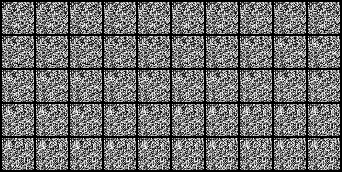

In [15]:
torchvision.transforms.ToPILImage()(torchvision.utils.make_grid((final_images[0]+1)/2, nrow=10, normalize=False))

> train the model 

In [16]:
# we will add EMA weights to the model. 
import copy

def exists(val):
    return val is not None

class EMA():
    def __init__(self, beta):
        super().__init__()
        self.beta = beta
    def update_average(self, old, new):
        if not exists(old):
            return new
        return old * self.beta + (1 - self.beta) * new

ema = EMA(beta=0.9999)
ema_model = copy.deepcopy(model)

In [17]:
epochs = 100 
optimizer = torch.optim.Adam(model.parameters(), lr=2e-4, weight_decay=1e-5)
total_steps = len(train_loader) * epochs
tdist = torch.distributions.Uniform(0, 1)

iter = 0 
train_loss = []

for epoch in range(epochs):
    model.train()
    epoch_loss = []
    with tqdm(train_loader, unit="batch") as tepoch:
        for batch in tepoch:
            optimizer.zero_grad()
            
            x1, _ = batch
            x1 = 2*x1.to(device) - 1
            noise = torch.randn((x1.shape[0], 1, 32, 32), device=device)
            t = tdist.sample((x1.shape[0],)).unsqueeze(1).unsqueeze(1).unsqueeze(1).to(device)
            xt = t*x1 + (1-t)*noise
            target = x1 - noise 
            model_output = model(xt.to(device), t.flatten(0).to(device))["sample"]
            
            loss = torch.nn.functional.mse_loss(model_output, target.to(device))
            loss.backward()
            #torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)  # Add gradient clipping
            optimizer.step()

            #calculate loss 
            tepoch.set_postfix(loss=loss.item())
            epoch_loss.append(loss.item())
                    
            #update ema model 
            for current_params, ma_params in zip(model.parameters(), ema_model.parameters()):
                    old_weight, up_weight = ma_params.data, current_params.data
                    ma_params.data = ema.update_average(old_weight, up_weight)
    
    train_loss.extend(epoch_loss)
    store = {
         "ema_model": ema_model.state_dict(),
         "model": model.state_dict(),
         "train_loss": np.mean(epoch_loss)
    }
    torch.save(store, f"generated/ema_model_{epoch}_{np.mean(epoch_loss):3f}.pth")
    print(f"Epoch {epoch} completed: train loss {np.mean(epoch_loss)}")
    #TODO: calculate some metric between generated images and original images

    ema_model.eval()
    out= sample_images(ema_model, 4, device)
    out = (out+1)/2
    img = torchvision.transforms.ToPILImage()(torchvision.utils.make_grid(out[0].cpu(), nrow=10, normalize=True))
    img.save(f"generated/generated_images_{epoch}.png")
        

100%|██████████| 469/469 [00:29<00:00, 16.07batch/s, loss=0.158]


Epoch 0 completed: train loss 0.2129780577698242


50it [00:00, 74.09it/s]
100%|██████████| 469/469 [00:28<00:00, 16.39batch/s, loss=0.157]


Epoch 1 completed: train loss 0.15608103023663258


50it [00:00, 81.35it/s]
100%|██████████| 469/469 [00:28<00:00, 16.41batch/s, loss=0.145]


Epoch 2 completed: train loss 0.1479717708155036


50it [00:00, 82.50it/s]
100%|██████████| 469/469 [00:28<00:00, 16.43batch/s, loss=0.128]


Epoch 3 completed: train loss 0.14441421078339314


50it [00:00, 80.91it/s]
100%|██████████| 469/469 [00:28<00:00, 16.42batch/s, loss=0.133]


Epoch 4 completed: train loss 0.14223615685378566


50it [00:00, 80.92it/s]
100%|██████████| 469/469 [00:28<00:00, 16.40batch/s, loss=0.149]


Epoch 5 completed: train loss 0.14008427927616054


50it [00:00, 82.03it/s]
100%|██████████| 469/469 [00:28<00:00, 16.43batch/s, loss=0.133]


Epoch 6 completed: train loss 0.13897149878015905


50it [00:00, 81.34it/s]
100%|██████████| 469/469 [00:28<00:00, 16.42batch/s, loss=0.134]


Epoch 7 completed: train loss 0.1376101198290457


50it [00:00, 81.57it/s]
100%|██████████| 469/469 [00:28<00:00, 16.45batch/s, loss=0.13] 


Epoch 8 completed: train loss 0.13629887235571325


50it [00:00, 81.87it/s]
100%|██████████| 469/469 [00:28<00:00, 16.42batch/s, loss=0.154]


Epoch 9 completed: train loss 0.13685290693347132


50it [00:00, 81.00it/s]
100%|██████████| 469/469 [00:28<00:00, 16.48batch/s, loss=0.123]


Epoch 10 completed: train loss 0.13557237126171462


50it [00:00, 81.04it/s]
100%|██████████| 469/469 [00:28<00:00, 16.44batch/s, loss=0.147]


Epoch 11 completed: train loss 0.13428204748104375


50it [00:00, 81.95it/s]
100%|██████████| 469/469 [00:28<00:00, 16.44batch/s, loss=0.144]


Epoch 12 completed: train loss 0.1344030788744182


50it [00:00, 81.55it/s]
100%|██████████| 469/469 [00:28<00:00, 16.33batch/s, loss=0.134]


Epoch 13 completed: train loss 0.1333071116540732


50it [00:00, 80.73it/s]
100%|██████████| 469/469 [00:28<00:00, 16.32batch/s, loss=0.131]


Epoch 14 completed: train loss 0.13294848207154


50it [00:00, 82.25it/s]
100%|██████████| 469/469 [00:28<00:00, 16.39batch/s, loss=0.138]


Epoch 15 completed: train loss 0.13272103022283582


50it [00:00, 80.60it/s]
100%|██████████| 469/469 [00:28<00:00, 16.39batch/s, loss=0.121]


Epoch 16 completed: train loss 0.13305637701106732


50it [00:00, 80.73it/s]
100%|██████████| 469/469 [00:28<00:00, 16.40batch/s, loss=0.133]


Epoch 17 completed: train loss 0.1318115144332589


50it [00:00, 81.27it/s]
100%|██████████| 469/469 [00:28<00:00, 16.41batch/s, loss=0.143]


Epoch 18 completed: train loss 0.13174869539514025


50it [00:00, 80.95it/s]
100%|██████████| 469/469 [00:28<00:00, 16.41batch/s, loss=0.135]


Epoch 19 completed: train loss 0.13170151342588193


50it [00:00, 80.25it/s]
100%|██████████| 469/469 [00:28<00:00, 16.44batch/s, loss=0.123]


Epoch 20 completed: train loss 0.1317075671099905


50it [00:00, 81.75it/s]
100%|██████████| 469/469 [00:28<00:00, 16.47batch/s, loss=0.141]


Epoch 21 completed: train loss 0.1315174503271768


50it [00:00, 81.17it/s]
100%|██████████| 469/469 [00:28<00:00, 16.46batch/s, loss=0.119]


Epoch 22 completed: train loss 0.1308582734419847


50it [00:00, 81.17it/s]
100%|██████████| 469/469 [00:28<00:00, 16.43batch/s, loss=0.139]


Epoch 23 completed: train loss 0.13112929167905088


50it [00:00, 81.14it/s]
100%|██████████| 469/469 [00:28<00:00, 16.43batch/s, loss=0.128]


Epoch 24 completed: train loss 0.13094442217017033


50it [00:00, 80.75it/s]
100%|██████████| 469/469 [00:28<00:00, 16.35batch/s, loss=0.111]


Epoch 25 completed: train loss 0.1299503866765799


50it [00:00, 80.23it/s]
100%|██████████| 469/469 [00:28<00:00, 16.32batch/s, loss=0.132]


Epoch 26 completed: train loss 0.1301513593048175


50it [00:00, 81.91it/s]
100%|██████████| 469/469 [00:28<00:00, 16.40batch/s, loss=0.12] 


Epoch 27 completed: train loss 0.1300104311280159


50it [00:00, 79.30it/s]
100%|██████████| 469/469 [00:28<00:00, 16.38batch/s, loss=0.124]


Epoch 28 completed: train loss 0.1292794896786147


50it [00:00, 81.78it/s]
100%|██████████| 469/469 [00:28<00:00, 16.47batch/s, loss=0.124]


Epoch 29 completed: train loss 0.12994214418981628


50it [00:00, 81.51it/s]
100%|██████████| 469/469 [00:28<00:00, 16.47batch/s, loss=0.118]


Epoch 30 completed: train loss 0.12989499173693056


50it [00:00, 80.56it/s]
100%|██████████| 469/469 [00:28<00:00, 16.46batch/s, loss=0.132]


Epoch 31 completed: train loss 0.13023273643654293


50it [00:00, 80.78it/s]
100%|██████████| 469/469 [00:28<00:00, 16.45batch/s, loss=0.13] 


Epoch 32 completed: train loss 0.12930210133287698


50it [00:00, 82.15it/s]
100%|██████████| 469/469 [00:28<00:00, 16.45batch/s, loss=0.126]


Epoch 33 completed: train loss 0.12941532043505832


50it [00:00, 80.41it/s]
100%|██████████| 469/469 [00:28<00:00, 16.46batch/s, loss=0.124]


Epoch 34 completed: train loss 0.1292627434581836


50it [00:00, 80.72it/s]
100%|██████████| 469/469 [00:28<00:00, 16.45batch/s, loss=0.139]


Epoch 35 completed: train loss 0.12945995659335083


50it [00:00, 82.17it/s]
100%|██████████| 469/469 [00:28<00:00, 16.45batch/s, loss=0.111]


Epoch 36 completed: train loss 0.12946927692018337


50it [00:00, 81.12it/s]
100%|██████████| 469/469 [00:28<00:00, 16.43batch/s, loss=0.137]


Epoch 37 completed: train loss 0.12935246269840167


50it [00:00, 80.99it/s]
100%|██████████| 469/469 [00:28<00:00, 16.43batch/s, loss=0.12] 


Epoch 38 completed: train loss 0.1286332365006272


50it [00:00, 81.73it/s]
100%|██████████| 469/469 [00:28<00:00, 16.44batch/s, loss=0.143]


Epoch 39 completed: train loss 0.12878825539337801


50it [00:00, 80.94it/s]
100%|██████████| 469/469 [00:28<00:00, 16.43batch/s, loss=0.108]


Epoch 40 completed: train loss 0.12881612618848967


50it [00:00, 81.47it/s]
100%|██████████| 469/469 [00:28<00:00, 16.37batch/s, loss=0.108]


Epoch 41 completed: train loss 0.12842438654350574


50it [00:00, 80.96it/s]
100%|██████████| 469/469 [00:28<00:00, 16.41batch/s, loss=0.118]


Epoch 42 completed: train loss 0.12912053108088242


50it [00:00, 81.17it/s]
100%|██████████| 469/469 [00:28<00:00, 16.40batch/s, loss=0.147]


Epoch 43 completed: train loss 0.12895081875357292


50it [00:00, 80.61it/s]
100%|██████████| 469/469 [00:28<00:00, 16.41batch/s, loss=0.121]


Epoch 44 completed: train loss 0.12873173424048717


50it [00:00, 81.83it/s]
100%|██████████| 469/469 [00:28<00:00, 16.40batch/s, loss=0.134]


Epoch 45 completed: train loss 0.1287149193603347


50it [00:00, 80.38it/s]
100%|██████████| 469/469 [00:28<00:00, 16.40batch/s, loss=0.109]


Epoch 46 completed: train loss 0.12822579074579515


50it [00:00, 80.69it/s]
100%|██████████| 469/469 [00:28<00:00, 16.40batch/s, loss=0.127]


Epoch 47 completed: train loss 0.1287387966442464


50it [00:00, 81.63it/s]
100%|██████████| 469/469 [00:28<00:00, 16.43batch/s, loss=0.117]


Epoch 48 completed: train loss 0.128259008913152


50it [00:00, 81.24it/s]
100%|██████████| 469/469 [00:28<00:00, 16.39batch/s, loss=0.124]


Epoch 49 completed: train loss 0.12846284180180603


50it [00:00, 80.71it/s]
100%|██████████| 469/469 [00:28<00:00, 16.42batch/s, loss=0.124]


Epoch 50 completed: train loss 0.12847523194259164


50it [00:00, 81.66it/s]
100%|██████████| 469/469 [00:28<00:00, 16.42batch/s, loss=0.141]


Epoch 51 completed: train loss 0.12775196895988256


50it [00:00, 80.90it/s]
100%|██████████| 469/469 [00:28<00:00, 16.44batch/s, loss=0.129]


Epoch 52 completed: train loss 0.1282121381049217


50it [00:00, 80.69it/s]
100%|██████████| 469/469 [00:28<00:00, 16.43batch/s, loss=0.128]


Epoch 53 completed: train loss 0.1277820232993504


50it [00:00, 81.23it/s]
100%|██████████| 469/469 [00:28<00:00, 16.43batch/s, loss=0.135]


Epoch 54 completed: train loss 0.12811187287764764


50it [00:00, 81.59it/s]
100%|██████████| 469/469 [00:28<00:00, 16.44batch/s, loss=0.131]


Epoch 55 completed: train loss 0.12820427327839803


50it [00:00, 80.33it/s]
100%|██████████| 469/469 [00:28<00:00, 16.41batch/s, loss=0.122]


Epoch 56 completed: train loss 0.1283448358207369


50it [00:00, 81.61it/s]
100%|██████████| 469/469 [00:28<00:00, 16.43batch/s, loss=0.133]


Epoch 57 completed: train loss 0.128536754992725


50it [00:00, 80.67it/s]
100%|██████████| 469/469 [00:28<00:00, 16.45batch/s, loss=0.135]


Epoch 58 completed: train loss 0.12745418248654428


50it [00:00, 81.20it/s]
100%|██████████| 469/469 [00:28<00:00, 16.43batch/s, loss=0.129]


Epoch 59 completed: train loss 0.12748585941631402


50it [00:00, 81.43it/s]
100%|██████████| 469/469 [00:28<00:00, 16.44batch/s, loss=0.123]


Epoch 60 completed: train loss 0.127457749201799


50it [00:00, 81.50it/s]
100%|██████████| 469/469 [00:28<00:00, 16.42batch/s, loss=0.13] 


Epoch 61 completed: train loss 0.12766317997787044


50it [00:00, 80.30it/s]
100%|██████████| 469/469 [00:28<00:00, 16.42batch/s, loss=0.115]


Epoch 62 completed: train loss 0.1274389704343861


50it [00:00, 81.50it/s]
100%|██████████| 469/469 [00:28<00:00, 16.44batch/s, loss=0.121]


Epoch 63 completed: train loss 0.1283255998196124


50it [00:00, 80.41it/s]
100%|██████████| 469/469 [00:28<00:00, 16.40batch/s, loss=0.135]


Epoch 64 completed: train loss 0.12720224504341196


50it [00:00, 80.85it/s]
100%|██████████| 469/469 [00:28<00:00, 16.37batch/s, loss=0.124]


Epoch 65 completed: train loss 0.12795465225095687


50it [00:00, 80.73it/s]
100%|██████████| 469/469 [00:28<00:00, 16.40batch/s, loss=0.132]


Epoch 66 completed: train loss 0.12726414564258254


50it [00:00, 81.06it/s]
100%|██████████| 469/469 [00:28<00:00, 16.42batch/s, loss=0.138]


Epoch 67 completed: train loss 0.12795161500350752


50it [00:00, 79.69it/s]
100%|██████████| 469/469 [00:28<00:00, 16.37batch/s, loss=0.13] 


Epoch 68 completed: train loss 0.12742257909352844


50it [00:00, 81.46it/s]
100%|██████████| 469/469 [00:28<00:00, 16.42batch/s, loss=0.128]


Epoch 69 completed: train loss 0.1276073158740489


50it [00:00, 80.80it/s]
100%|██████████| 469/469 [00:28<00:00, 16.38batch/s, loss=0.127]


Epoch 70 completed: train loss 0.12723055191195087


50it [00:00, 80.64it/s]
100%|██████████| 469/469 [00:28<00:00, 16.39batch/s, loss=0.139]


Epoch 71 completed: train loss 0.1276513639289433


50it [00:00, 80.76it/s]
100%|██████████| 469/469 [00:28<00:00, 16.42batch/s, loss=0.118]


Epoch 72 completed: train loss 0.12771066387833307


50it [00:00, 81.32it/s]
100%|██████████| 469/469 [00:28<00:00, 16.37batch/s, loss=0.125]


Epoch 73 completed: train loss 0.1270574854889404


50it [00:00, 80.48it/s]
100%|██████████| 469/469 [00:28<00:00, 16.40batch/s, loss=0.127]


Epoch 74 completed: train loss 0.1271235358549842


50it [00:00, 81.66it/s]
100%|██████████| 469/469 [00:28<00:00, 16.45batch/s, loss=0.121]


Epoch 75 completed: train loss 0.1268921682257642


50it [00:00, 80.78it/s]
100%|██████████| 469/469 [00:28<00:00, 16.37batch/s, loss=0.113]


Epoch 76 completed: train loss 0.1272113466980869


50it [00:00, 80.38it/s]
100%|██████████| 469/469 [00:28<00:00, 16.36batch/s, loss=0.121]


Epoch 77 completed: train loss 0.1267460038158685


50it [00:00, 80.91it/s]
100%|██████████| 469/469 [00:28<00:00, 16.38batch/s, loss=0.138]


Epoch 78 completed: train loss 0.1269842128573196


50it [00:00, 81.11it/s]
100%|██████████| 469/469 [00:28<00:00, 16.37batch/s, loss=0.113]


Epoch 79 completed: train loss 0.1268669556198852


50it [00:00, 79.57it/s]
100%|██████████| 469/469 [00:28<00:00, 16.36batch/s, loss=0.112]


Epoch 80 completed: train loss 0.12717409520896514


50it [00:00, 81.64it/s]
100%|██████████| 469/469 [00:28<00:00, 16.41batch/s, loss=0.125]


Epoch 81 completed: train loss 0.12671299815686274


50it [00:00, 80.49it/s]
100%|██████████| 469/469 [00:28<00:00, 16.35batch/s, loss=0.129]


Epoch 82 completed: train loss 0.12674942653951868


50it [00:00, 80.37it/s]
100%|██████████| 469/469 [00:28<00:00, 16.34batch/s, loss=0.125]


Epoch 83 completed: train loss 0.12701415794808218


50it [00:00, 80.85it/s]
100%|██████████| 469/469 [00:28<00:00, 16.41batch/s, loss=0.127]


Epoch 84 completed: train loss 0.12726707874076454


50it [00:00, 80.93it/s]
100%|██████████| 469/469 [00:28<00:00, 16.42batch/s, loss=0.137]


Epoch 85 completed: train loss 0.12617213016888226


50it [00:00, 80.54it/s]
100%|██████████| 469/469 [00:28<00:00, 16.37batch/s, loss=0.12] 


Epoch 86 completed: train loss 0.12695018446712353


50it [00:00, 81.05it/s]
100%|██████████| 469/469 [00:28<00:00, 16.38batch/s, loss=0.12] 


Epoch 87 completed: train loss 0.1267095601825572


50it [00:00, 80.77it/s]
100%|██████████| 469/469 [00:28<00:00, 16.37batch/s, loss=0.11] 


Epoch 88 completed: train loss 0.12640241322232715


50it [00:00, 80.19it/s]
100%|██████████| 469/469 [00:28<00:00, 16.34batch/s, loss=0.128]


Epoch 89 completed: train loss 0.12712518119418037


50it [00:00, 81.39it/s]
100%|██████████| 469/469 [00:28<00:00, 16.38batch/s, loss=0.111]


Epoch 90 completed: train loss 0.12697657277144347


50it [00:00, 80.93it/s]
100%|██████████| 469/469 [00:28<00:00, 16.36batch/s, loss=0.129]


Epoch 91 completed: train loss 0.1269563581389405


50it [00:00, 80.60it/s]
100%|██████████| 469/469 [00:28<00:00, 16.36batch/s, loss=0.131]


Epoch 92 completed: train loss 0.12660141049354062


50it [00:00, 81.49it/s]
100%|██████████| 469/469 [00:28<00:00, 16.41batch/s, loss=0.137]


Epoch 93 completed: train loss 0.12693341535482325


50it [00:00, 81.06it/s]
100%|██████████| 469/469 [00:28<00:00, 16.39batch/s, loss=0.122]


Epoch 94 completed: train loss 0.12671670757694795


50it [00:00, 80.61it/s]
100%|██████████| 469/469 [00:28<00:00, 16.34batch/s, loss=0.115]


Epoch 95 completed: train loss 0.12720841738079658


50it [00:00, 80.88it/s]
100%|██████████| 469/469 [00:28<00:00, 16.39batch/s, loss=0.14] 


Epoch 96 completed: train loss 0.12656239620340404


50it [00:00, 81.28it/s]
100%|██████████| 469/469 [00:28<00:00, 16.38batch/s, loss=0.135]


Epoch 97 completed: train loss 0.12631621512014474


50it [00:00, 79.85it/s]
100%|██████████| 469/469 [00:28<00:00, 16.33batch/s, loss=0.117]


Epoch 98 completed: train loss 0.12675852801944656


50it [00:00, 82.16it/s]
100%|██████████| 469/469 [00:28<00:00, 16.45batch/s, loss=0.124]


Epoch 99 completed: train loss 0.1257942779930924


50it [00:00, 80.19it/s]


In [18]:
# model.load_state_dict(torch.load("generated/ema_model_99_0.125880.pth", map_location=device, weights_only=False)["model"])
# print("model loaded")

50it [00:00, 72.35it/s]


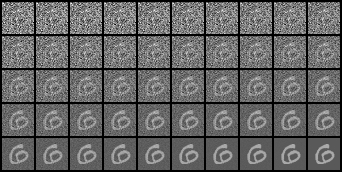

In [19]:
model.eval()
out = sample_images(model, 64, device)
out = (out+1)/2
img = torchvision.transforms.ToPILImage()(torchvision.utils.make_grid(out[0].cpu(), nrow=10, normalize=True))
img

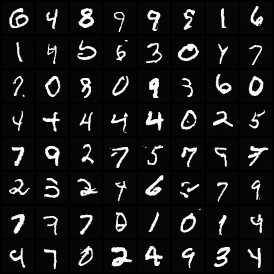

In [20]:
torchvision.transforms.ToPILImage()(torchvision.utils.make_grid(out[:, -1, ...].clamp(-1, 1).cpu(), nrow=8, normalize=True))

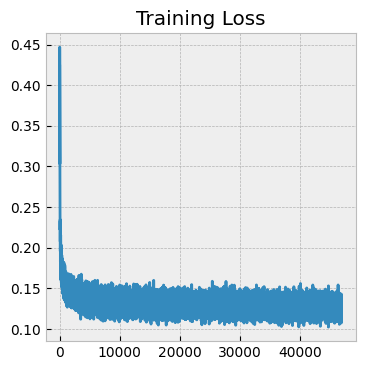

In [21]:
plt.figure(figsize=(4, 4))
plt.plot(train_loss[10:])
plt.title("Training Loss")
plt.show()

##  reverse flow is possible. 


we should be able to go back to noise and then flow back again to the same image.

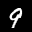

In [22]:
torchvision.transforms.ToPILImage()(imgs[12])

In [23]:
x1 = imgs[12].unsqueeze(0)
x1 = 2*x1-1
time_steps = torch.linspace(1, 0, 50)
x1.shape, time_steps.shape, x1.max(), x1.min()

(torch.Size([1, 1, 32, 32]), torch.Size([50]), tensor(1.), tensor(-1.))

In [24]:
outs = []
for i, t in tqdm(enumerate(time_steps)):
    if i == 0:
        xt = x1
    else:
        dt = time_steps[i-1] - time_steps[i]
        with torch.no_grad():
            out = model(xt.cuda(), t.repeat(1).cuda())["sample"].detach().cpu()
        xt = xt - dt*out
    outs.append(xt.squeeze(0))

outs = torch.stack(outs)
outs.shape

50it [00:00, 74.25it/s]


torch.Size([50, 1, 32, 32])

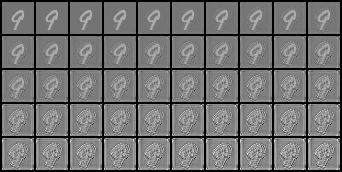

In [25]:
torchvision.transforms.ToPILImage()(torchvision.utils.make_grid(outs, nrow=10, normalize=True))

> Lets plot a histogram and see how distribution changed from image space to noise.

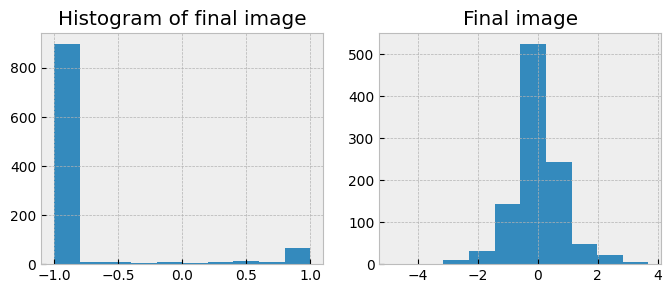

In [26]:
fig, ax = plt.subplots(1, 2, figsize=(8, 3))
ax[0].hist(outs[0].flatten().cpu().numpy())
ax[0].set_title("Histogram of final image")
ax[1].hist(outs[-1].flatten().cpu().numpy())
ax[1].set_title("Final image")
plt.show()

> reconstruct from noise. 

In [27]:
noise = outs[-1].unsqueeze(0)
time_steps = torch.linspace(0, 1, 50)
outs_forward = []
for i, t in tqdm(enumerate(time_steps)):
    if i == 0:
        xt = noise
    else:
        dt = time_steps[i] - time_steps[i-1]
        with torch.no_grad():
            xt = xt + dt*model(xt.cuda(), t.repeat(1).cuda())["sample"].detach().cpu()
    outs_forward.append(xt.squeeze(0))
outs_forward = torch.stack(outs_forward)
outs_forward.shape

50it [00:00, 80.62it/s]


torch.Size([50, 1, 32, 32])

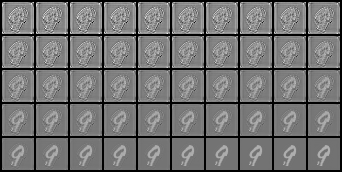

In [28]:
torchvision.transforms.ToPILImage()(torchvision.utils.make_grid(outs_forward, nrow=10, normalize=True))

## FID scores
Lets generate some 10k images and calculate FID scores. 

In [29]:
from torchmetrics.image.fid import FrechetInceptionDistance

fid = FrechetInceptionDistance(feature=2048).cuda()

for n, ds in enumerate(val_loader):
    x1, _ = ds
    x1 = 2*x1.to(device) - 1
    generated_images = sample_images(ema_model, x1.shape[0], device)
    generated_images = generated_images[:, -1, ...].clamp(-1, 1)
    generated_images = torch.concat([generated_images, generated_images, generated_images], axis=1) 
    x1 = torch.concat([x1, x1, x1], axis=1)
    fid.update((255*(generated_images+1)/2).to(torch.uint8), real=False)
    fid.update((255*(x1+1)/2).to(torch.uint8), real=True)
fid_score = fid.compute()
fid_score




50it [00:00, 79.21it/s]
50it [00:00, 81.96it/s]
50it [00:00, 81.70it/s]
50it [00:00, 81.76it/s]
50it [00:00, 81.72it/s]
50it [00:00, 82.07it/s]
50it [00:00, 81.47it/s]
50it [00:00, 82.01it/s]
50it [00:00, 82.01it/s]
50it [00:00, 81.93it/s]
50it [00:00, 81.78it/s]
50it [00:00, 81.82it/s]
50it [00:00, 81.91it/s]
50it [00:00, 81.91it/s]
50it [00:00, 81.93it/s]
50it [00:00, 81.81it/s]
50it [00:00, 81.63it/s]
50it [00:00, 82.15it/s]
50it [00:00, 82.49it/s]
50it [00:00, 82.75it/s]
50it [00:00, 82.62it/s]
50it [00:00, 82.66it/s]
50it [00:00, 82.55it/s]
50it [00:00, 82.65it/s]
50it [00:00, 82.49it/s]
50it [00:00, 82.56it/s]
50it [00:00, 82.49it/s]
50it [00:00, 82.67it/s]
50it [00:00, 82.57it/s]
50it [00:00, 82.65it/s]
50it [00:00, 82.76it/s]
50it [00:00, 82.77it/s]
50it [00:00, 82.67it/s]
50it [00:00, 82.64it/s]
50it [00:00, 82.57it/s]
50it [00:00, 82.78it/s]
50it [00:00, 82.78it/s]
50it [00:00, 82.67it/s]
50it [00:00, 82.73it/s]
50it [00:00, 82.68it/s]
50it [00:00, 82.57it/s]
50it [00:00, 82.

tensor(54.6250, device='cuda:0')

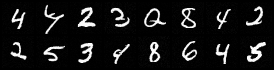

In [30]:
torchvision.transforms.ToPILImage()(torchvision.utils.make_grid(generated_images[:64], nrow=8, normalize=True))

> though visually the images look very nice, the fid score is really high

TODO: check why fid scores are high

## Now lets see if ODE solvers can be used to generate samples. 

this allow us to see if we can further reduce the number of evaluation steps.

In [31]:
def flow_ode(t, x, model):
    """
    Define the ODE for the flow model
    dx/dt = model(x, t)
    """
    batch_size = x.shape[0]
    t = t.repeat(batch_size)
    return model(x, t)["sample"]

In [34]:
from torchdiffeq import odeint

def sample_images_rk45(model, n_samples, device, rtol=1e-5, atol=1e-5):
    model.eval()
    
    # Initial condition (noise)
    x0 = torch.randn((n_samples, 1, 32, 32), device=device)
    
    # Time points to evaluate
    t = torch.linspace(0, 1, 50).to(device)  # start and end points
    
    # Solve ODE
    with torch.no_grad():
        solution = odeint(
            lambda t, x: flow_ode(t, x, model),
            x0,
            t,
            method='dopri5',  # RK45
            rtol=rtol,
            atol=atol
        )
    
    return solution[-1]  # Return final state

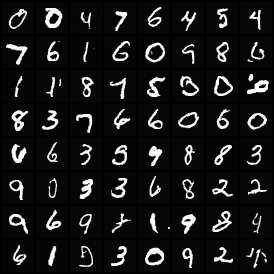

In [35]:
generated_images = sample_images_rk45(model, 64, device)
generated_images = (generated_images+1)/2
torchvision.transforms.ToPILImage()(torchvision.utils.make_grid(generated_images.clamp(-1, 1).cpu(), nrow=8, normalize=True))
